<h1>Plushie Defense Game Analysis</h1>

<p>Plushie Defense is a puzzle strategic game developed by <a href="https://raccoopack.com/plushiedefense">Raccoopack Studios</a>, Vancouver. The game has two versions; Version 1 was tested between January 7th and 21st, and version 2 was between January 22nd and February 4th. 70 testers have played the game during that period and produced 9420 interaction events which are later stored into a dataset.</p>
<p>This notebook is going to analyze the dataset, and to answer several questions coming from the company. The questions are:</p>
<ul>
    <li>What level players drop off at?</li>
    <li>How long was their play session?</li>
    <li>What level a player spends the longest time in - and how it relates to the drop-off?</li>
    <li>How many attempts on each level?</li>
    <li>What's players' favorite winning team competition?</li>
</ul>
<p><a href="https://raccoopack.com/plushiedefense"><img src="background.png" alt="the background image of Plushie Defence" width="100%" height="auto" /></a>
</p>

<h2>1. Load the dataset</h2>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from itertools import product
import json
import os
from pandas.io.json import json_normalize
from datetime import datetime, timedelta
from pytz import timezone
import pytz
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [2]:
# Load the CSV data into DataFrames
df_read_path = "../data/Events02042020.csv"
df = pd.read_csv(df_read_path)

# Display the first five rows
display(df.head())

,EventID,Data,Event,PlayerID,Time
0,0bQFrHObSJrQBOb8xqPSaw,"{""message"":{""endSource"":""WIN"",""level"":""level_2...",END_GAME,0bcdb69da2a4dfe7bb5dbb5678e47f35,Tue Jan 07 2020 20:31:02 GMT+0000 (Coordinated...
1,FMojjST-bb4C3YzQ4PeYIQ,"{""Attempt"":1,""Level"":""intro_2"",""Formation"":""Bo...",START_GAME,BBD84E3D-DD15-4CFB-BCC0-E4724F3A8689,Sun Jan 26 2020 22:12:16 GMT+0000 (Coordinated...
2,5MXt8iOFQsPfR3lCjHjhZw,"{""Level"":""level_6"",""Formation"":""Doori,Fya,Sir ...",SELECT_LEVEL,41BCB9B5-E120-4263-AFCC-0EE41ED11EDD,Sat Feb 01 2020 00:19:01 GMT+0000 (Coordinated...
3,hqfCHYnPFzIg6u5QfYTMOQ,"{""message"":{""endSource"":""LOSE"",""level"":""level_...",END_GAME,212675EB-EAD6-40F7-8170-BD15C5440FB4,Tue Jan 28 2020 06:52:38 GMT+0000 (Coordinated...
4,MB37V1ZiPxoZAo_idWEORg,"{""Level"":""level_6"",""Formation"":""Doori,Sir Atch...",EDIT_TEAM,0b5169d19638999753e3d00fc6fa7ef9,Tue Jan 07 2020 19:45:20 GMT+0000 (Coordinated...


<p>As shown in the above display result, column 'Data' in the dataset contains JSON object. This column will be flattened using the following 'load_df' function which is adopted from <a href="https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook">Julian Peller</a>. After the JSON object flattening, the dataset df have 12 columns.</p>

In [3]:
"""
Function load_df(csv_path, nrows)
    This function reads a dataset, flattens the JSON columns in json_cols list, and 
    contructs a dataframe that contains columns written in the use_cols list. The use_cols is needed 
    to prevent column duplicates after JSON flattening.
Input:
    1. csv_path: the dataset's file name to load.
    2. nrows: number of rows to read during the data loading.
Output:
    A dataframe of the dataset.

"""
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['Data']
    df = pd.read_csv(csv_path,
                     converters = {column: json.loads for column in JSON_COLUMNS},
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df


# Read dataset and flatten the JSON object
df_read_path = "../data/Events02042020.csv"
df = load_df(csv_path=df_read_path, nrows=None)

Loaded Events02042020.csv. Shape: (9420, 12)


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9420 entries, 0 to 9419
Data columns (total 12 columns):
EventID                   9420 non-null object
Event                     9420 non-null object
PlayerID                  9420 non-null object
Time                      9420 non-null object
Data.message.endSource    2122 non-null object
Data.message.level        2122 non-null object
Data.message.team         2122 non-null object
Data.Attempt              2857 non-null float64
Data.Level                6053 non-null object
Data.Formation            5191 non-null object
Data.Source               2638 non-null object
Data.IsNewPlayer          1243 non-null object
dtypes: float64(1), object(11)
memory usage: 883.2+ KB
None


<h2>2. Examining the dataset df</h2>

<h3>2.1. Convert string type 'Time' column to datetime data type</h3>
<p>The 'Time' column has string data type and GMT+0000 (Coordinated Universal Time) timezone. This string object needs to be converted to datetime object and Pacific timezone.</p>
<p>For the time interval calculation, the actual timezone is not crucial. However, the localized timezone make better understanding why a player take a long pause, and help us to develop an accurate calculation on session's time.</p>

In [5]:
"""
Function convert_time_to_datetime()
    This function slices string 'Tue Jan 07 2020 20:31:02 GMT+0000 (Coordinated Universal Time)' 
    to get only 'Jan 07 2020 20:31:02 GMT+0000'. Then, convert the string to datetime type, and 
    convert the timezone from GMT to Canada/Pacific. The function also creates 'Date_Time' 
    column and drops the 'Time' column from the dataframe.
"""
def convert_time_to_datetime():
    # Slice the 'Time' string to get only 'Jan 07 2020 20:31:02 GMT+0000'
    # Convert from string type to datetime type
    # And convert the timezone from GMT to Canada/Pacific 
    df['Date_Time'] = pd.to_datetime(df['Time'].str.slice(start=4, stop=33)).dt.tz_convert('Canada/Pacific')

    #drop column 'Time'
    df.drop('Time', axis = 1, inplace=True)
    return

# Convert time to datetime
convert_time_to_datetime()

<h3>2.2. Fill in the missing values</h3>
<p>The printout of the dataframe information shows that eight columns have a significant number of missing values. Apparently, three pairs of them contain values that are completing each other: 'Data.message.endSource' and 'Source'; 'Data.message.level' and 'Data.Level'; 'Data.message.team' and 'Data.Formation'. To make the analysis easier, two columns that are completing each other will be combined into one new column. So that, there will be three new columns 'Source', 'Level' and 'Team' respectively. Later, the missing values in three new columns, 'Data.Attempt' and 'Data.IsNewPlayer' will be filled up with string 'missing' or 0.</p>
<p>The Plushie Defence game has total 20 levels, intro_1 to intro_4 and level_1 to level_16. To make the iteration through the levels easier, one new column will be added into the dataframe. This new column contains the mapping of levels into integers between 1 and 20.</p>

In [36]:
columns = ['Event', 'Data.message.endSource', 'Data.Source']
values = ['END_GAME','RETRY_GAME','WINDOW_CLOSED','GAME_CLOSED']
display(df[(df['PlayerID'] == 'BBD84E3D-DD15-4CFB-BCC0-E4724F3A8689') & (df['Event'].isin(values))][columns].head())

,Event,Data.message.endSource,Data.Source
14,RETRY_GAME,missing,PAUSE_MENU
553,END_GAME,LOSE,missing
711,WINDOW_CLOSED,missing,FORMATION_POPUP
813,END_GAME,LOSE,missing
1146,END_GAME,WIN,missing


In [7]:
"""
Function gather_columns(dataframe, column1, column2, column3)
    This function bring together column1 and column2, and 
    fill the missing values with 'missing' string.
"""
def gather_columns(dataframe, column1, column2, column3):
    dataframe[column3] = dataframe[column1]
    #Fill the missing value with values of 'Data.Source'
    dataframe[column3].fillna(dataframe[column2], inplace=True)
    #Fill the missing value with 'missing'
    dataframe[column3].fillna('missing', inplace=True)
    #Fill in the missing value in column1 and column2
    dataframe[column1].fillna('missing', inplace=True)
    dataframe[column2].fillna('missing', inplace=True)
    return dataframe

In [8]:
# Gather 'Data.message.endSource' and 'Data.Source'
df = gather_columns(df, 'Data.message.endSource', 'Data.Source', 'Source')

In [9]:
# Gather 'Data.message.team' and 'Data.Formation'
df = gather_columns(df, 'Data.message.team', 'Data.Formation', 'Team')

In [10]:
# Gather 'Data.message.level' and 'Data.Level'.
df = gather_columns(df, 'Data.message.level', 'Data.Level', 'Level')

In [11]:
"""
Map the string type Level to integer type Level's label 'Level_lbl' to make it easy to sort or to loop. 
There are 'missing' value in the column. How will it be mapped? The 'missing' value will be mapped to 
NaN which is going to replace with 0
"""
# Map the level to Level_Lbl
level_lbl_map = {'intro_1' : 1, 'intro_2' : 2, 'intro_3' : 3, 'intro_4' : 4, 'level_1' : 5, 'level_2' : 6, 'level_3' : 7, 'level_4' : 8, 'level_5' : 9, 'level_6' : 10, 'level_7' : 11, 'level_8' : 12, 'level_9' : 13, 'level_10' : 14, 'level_11' : 15, 'level_12' : 16, 'level_13' : 17, 'level_14' : 18, 'level_15' : 19, 'level_16' : 20}
df['Level_lbl'] = df['Level'].map(level_lbl_map)
df['Level_lbl'].fillna(0, inplace=True)

In [12]:
# Fill the missing value in 'Data.Attempt' with 0
df['Data.Attempt'].fillna(0, inplace=True)

In [13]:
"""
Column 'Data.IsNewPlayer' contains boolean data type. However it contains a lot of missing values, so that 
it will be replaced with 'missing' value.
"""
# Fill the missing value in 'Data.IsNewPlayer' with 'missing'
df['Data.IsNewPlayer'].fillna('missing', inplace=True)

In [14]:
# Dataframe after tidying up
display(df.head(7))

,EventID,Event,PlayerID,Data.message.endSource,Data.message.level,Data.message.team,Data.Attempt,Data.Level,Data.Formation,Data.Source,Data.IsNewPlayer,Date_Time,Source,Team,Level,Level_lbl
0,0bQFrHObSJrQBOb8xqPSaw,END_GAME,0bcdb69da2a4dfe7bb5dbb5678e47f35,WIN,level_2,"Bob,Marto,Cloud,Fya,",0.0,missing,missing,missing,missing,2020-01-07 12:31:02-08:00,WIN,"Bob,Marto,Cloud,Fya,",level_2,6.0
1,FMojjST-bb4C3YzQ4PeYIQ,START_GAME,BBD84E3D-DD15-4CFB-BCC0-E4724F3A8689,missing,missing,missing,1.0,intro_2,"Bob,Marto,Cloud,Fya,",missing,missing,2020-01-26 14:12:16-08:00,missing,"Bob,Marto,Cloud,Fya,",intro_2,2.0
2,5MXt8iOFQsPfR3lCjHjhZw,SELECT_LEVEL,41BCB9B5-E120-4263-AFCC-0EE41ED11EDD,missing,missing,missing,0.0,level_6,"Doori,Fya,Sir Atcha,Roxi, Yan Yan, and Gio,",missing,missing,2020-01-31 16:19:01-08:00,missing,"Doori,Fya,Sir Atcha,Roxi, Yan Yan, and Gio,",level_6,10.0
3,hqfCHYnPFzIg6u5QfYTMOQ,END_GAME,212675EB-EAD6-40F7-8170-BD15C5440FB4,LOSE,level_16,"Puka,Marto,Bob,Cloud,",0.0,missing,missing,missing,missing,2020-01-27 22:52:38-08:00,LOSE,"Puka,Marto,Bob,Cloud,",level_16,20.0
4,MB37V1ZiPxoZAo_idWEORg,EDIT_TEAM,0b5169d19638999753e3d00fc6fa7ef9,missing,missing,missing,0.0,level_6,"Doori,Sir Atcha,Bob,Fya,",missing,missing,2020-01-07 11:45:20-08:00,missing,"Doori,Sir Atcha,Bob,Fya,",level_6,10.0
5,9S4sYuwwAJJPwBb_4cCBhw,RETRY_GAME,A14A0192-A50F-4B2B-BD30-05A173C1675C,missing,missing,missing,2.0,level_3,"Bob,Marto,Cloud,Fya,",PAUSE_MENU,missing,2020-01-17 18:56:56-08:00,PAUSE_MENU,"Bob,Marto,Cloud,Fya,",level_3,7.0
6,o-JuwAzRyME9PjJGYzyDIQ,START_GAME,A14A0192-A50F-4B2B-BD30-05A173C1675C,missing,missing,missing,1.0,level_14,"Bob,Marto,Cloud,Fya,",missing,missing,2020-01-15 09:59:39-08:00,missing,"Bob,Marto,Cloud,Fya,",level_14,18.0


In [15]:
# Summarize the dataframe information
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9420 entries, 0 to 9419
Data columns (total 16 columns):
EventID                   9420 non-null object
Event                     9420 non-null object
PlayerID                  9420 non-null object
Data.message.endSource    9420 non-null object
Data.message.level        9420 non-null object
Data.message.team         9420 non-null object
Data.Attempt              9420 non-null float64
Data.Level                9420 non-null object
Data.Formation            9420 non-null object
Data.Source               9420 non-null object
Data.IsNewPlayer          9420 non-null object
Date_Time                 9420 non-null datetime64[ns, Canada/Pacific]
Source                    9420 non-null object
Team                      9420 non-null object
Level                     9420 non-null object
Level_lbl                 9420 non-null float64
dtypes: datetime64[ns, Canada/Pacific](1), float64(2), object(13)
memory usage: 1.2+ MB


<p>The info command shows that the dataframe doesn't contain null value anymore.</p>

In [16]:
# Convert the data type of columns 'Data.Attempt' and 'Level_lbl'
df["Data.Attempt"] = df["Data.Attempt"].astype("int64")
df["Level_lbl"] = df["Level_lbl"].astype("int64") 

In [17]:
# Columns to use in the analysis
columns = ["EventID", "Event", "PlayerID", "Data.Attempt", "Data.IsNewPlayer", "Date_Time", "Source", "Team", "Level", "Level_lbl"]

# Extract the dataframe df into three new dataframes: all versions, version 1 and version 2
df1 = df.loc[(df["Date_Time"] > "2020-01-06 23:59:59-08:00") & (df["Date_Time"] < "2020-01-22 00:00:00-08:00")][columns]
df2 = df.loc[(df["Date_Time"] > "2020-01-21 23:59:59-08:00") & (df["Date_Time"] < "2020-02-05 00:00:00-08:00")][columns]

<h2>3. Calculate Players Performance</h2>

<p>To answer the questions stated in the begining of this notebook, I need to calculate the players' performance on each level, the overall performance and the most favorit winning team. The performance dataframes will consist time spent on each level, the number of attempt on each level, the number of sessions, the dropoff levels, the longest time and the achievement on each level.</p>
<p>Besides the events generated by the real test players, the dataframes also contain the events that were created during the developer testing stage. These developer generated events should be filtered out from the dataframes. A real player has only one True value in the column of 'Data.IsNewPlayer'; this value is obtained when he/she installed the game in their mobile phone.</p>

In [18]:
"""
Function create_realplayer_list(dataframe)
    This function counts the number of True in Data.IsNewPlayer column for each PlayerID, and picks 
    the players having count 1. It generate new dataframe containing event's information of these real players.
    
    Input: dataframe
    Output: list of real player
"""
def create_realplayer_list(dataframe):
    #count the frequency of being a new player, and store the frequency to column 'NewPlayer_Count'
    isTruePlayer_count = dataframe[dataframe['Data.IsNewPlayer'] == True].groupby('PlayerID')['PlayerID'].agg(NewPlayer_Count=pd.NamedAgg(column='Data.IsNewPlayer', aggfunc='count')).reset_index()

    #create a list of playerID having ONCE being a new player
    real_player_list = isTruePlayer_count[isTruePlayer_count['NewPlayer_Count'] == 1]['PlayerID'].reset_index(drop=True)
    
    return real_player_list

In [19]:
"""
Function calculate_time_interval(t1, t2)
    This function calculates interval between two times
    
    Input: t1 and t2
    Output: time difference
"""
def calculate_time_interval(t1, t2):
    return (t2 - t1).total_seconds()

"""
Function calculate_time_Session(lvl_df, length, delta_t)
    This function calculates number of session and total time spent by a player to complete one level
    
    Input: dataframe lvl_df, length of the dataframe length, time interval delta_t
    Output: total time spent and number of session
"""
def calculate_time_Session(lvl_df, length, delta_t):
    session = 1
                
    # calculate the time interval between two events
    start = lvl_df.iloc[0, 1] # column 1 is 'Data_Time'
    end = lvl_df.iloc[length-1, 1]
    interval = calculate_time_interval(start, end)
    
    # calculate total time and sessions over all events in one level
    if (interval > delta_t): # if the sessions > 1 in this level
        
        temp_interval = 0 # initialize temporary interval 
 
        i = 0 # initialize index of event
        while (i < (length-2)): # examine event by event 
            
            i_interval = calculate_time_interval(lvl_df.iloc[i, 1], lvl_df.iloc[i+1, 1])
 
            if (i_interval < delta_t):
                temp_interval += i_interval
            else:
                session += 1
            i += 1  
        lvl_time = temp_interval 

    else: # if there is only one session in this level
        lvl_time = interval
        
    lvl_sessions = session
    
    return lvl_time, lvl_sessions

In [20]:
"""
Function calculate_performance_level(dataframe1, dataframe2, delta_t)
    This function calculates performance of a player to complete one level.
    The performance measured includes number of attempt, number of sessions, the achievement, 
    number of wins, number of lose and time to finish one level.
    
    Input: dataframe performance dataframe1, dataframe real player dataframe2, time interval
    Output: dataframe performance dataframe1
"""
def calculate_performance_level(dataframe1, dataframe2, delta_t):
    
    lvl_attempt = pd.Series()
    lvl_sessions = pd.Series()
    lvl_result = pd.Series()
    lvl_win = pd.Series()
    lvl_lose = pd.Series()
    lvl_time = pd.Series()
    
    # Loop through the dataframe:
    for idx in range(len(dataframe1)):
        
        # create temporary dataframe for each level
        pid = dataframe1.loc[idx,'PlayerID']
        lvl = dataframe1.loc[idx, 'label']
        lvl_df = dataframe2.loc[(dataframe2['PlayerID'] == pid) & (dataframe2['Level_lbl'] == lvl)].reset_index(drop=True)
    
        # calculate the time spent by pid on level lvl
        length = len(lvl_df.index)
        
        if (length > 0):
            lvl_time.at[idx], lvl_sessions.at[idx] = calculate_time_Session(lvl_df, length, delta_t)
            lvl_attempt.at[idx] = lvl_df['Data.Attempt'].max()
        else:
            lvl_sessions.at[idx]  = 0
            lvl_time.at[idx] = 0
            lvl_attempt.at[idx] = 0
        
        if (len(lvl_df[lvl_df['Source'] != 'missing']['Source']) > 0):
            lvl_result.at[idx] = lvl_df[lvl_df['Source'] != 'missing']['Source'].iloc[-1]
        else:
            lvl_result.at[idx] = 'missing'
            
        if (len(lvl_df[lvl_df['Source'] == 'WIN']['Source']) > 0):
            lvl_win.at[idx] = len(lvl_df[lvl_df['Source'] == 'WIN']['Source'])
        else: 
            lvl_win.at[idx] = 0
            
        if (len(lvl_df[lvl_df['Source'] == 'LOSE']['Source']) > 0):
            lvl_lose.at[idx] = len(lvl_df[lvl_df['Source'] == 'LOSE']['Source'])
        else:
            lvl_lose.at[idx] = 0
    
    dataframe1['lvl_attempt'] = lvl_attempt
    dataframe1['lvl_sessions'] = lvl_sessions
    dataframe1['lvl_time'] = lvl_time
    dataframe1['lvl_result'] = lvl_result
    dataframe1['lvl_win'] = lvl_win
    dataframe1['lvl_lose'] = lvl_lose
    
    return dataframe1

In [21]:
"""
Function calculate_performance_total(dataframe1, dataframe2, dataframe3, delta_t)
    This function calculates performance of a player throughout the game.
    The performance measured includes game session, total time and dropoff level.
    
    Input: dataframe summary dataframe1, dataframe real player dataframe2, levels' performance dataframe3, time interval
    Output: dataframe summary dataframe1
"""
def calculate_performance_total(dataframe1, dataframe2,dataframe3, delta_t):
    # Initialize series for session, time and dropoff level
    game_sessions = pd.Series()
    game_time = pd.Series()
    dropoff_level = pd.Series()
    longesttime_level = pd.Series()
    
    # Loop through the dataframe:
    for idx in range(len(dataframe1)):
        
        # Calculate session and time
        pid = dataframe1.loc[idx,'PlayerID'] # find the PlayerID at idx
        pid_df = dataframe2.loc[(dataframe2['PlayerID'] == pid)].reset_index(drop=True) # create dataframe of PlayerID
        length = len(pid_df.index) # find the lengeh of the PlayerID's dataframe
        
        if (length > 0):
            # Calculate the game's the amount of time and number of sessions to complete the game
            game_time.at[idx], game_sessions.at[idx] = calculate_time_Session(pid_df, length, delta_t)
        else:
            game_sessions.at[idx]  = 0
            game_time.at[idx] = 0
    
        # Find drop off level
        # Create dataframe of label from level's performance dataframe
        pid_df = dataframe3.loc[(dataframe3['PlayerID'] == pid) & (dataframe3['lvl_attempt'] > 0)]['label'].reset_index(drop=True)
        if not pid_df.empty:
            dropoff_level.at[idx] = pid_df.iloc[-1] # Get the last label in the dataframe
        else:
            dropoff_level.at[idx] = 0

            
        # Find the level of the longest time
        pid_df = dataframe3.loc[dataframe3['PlayerID']==pid].groupby('PlayerID').agg(maxtime=pd.NamedAgg(column='lvl_time', aggfunc='max'))
        if not pid_df.empty:
            max_time = pid_df.loc[pid].values.astype(int)[0]
            max_level = dataframe3.loc[dataframe3['lvl_time']==max_time]['label'].values.astype(int)[0]
            longesttime_level.at[idx] = max_level
        else:
            longesttime_level.at[idx] = 0
        
    dataframe1['game_sessions'] = game_sessions
    dataframe1['game_time'] = game_time
    dataframe1['dropoff_level'] = dropoff_level
    dataframe1['longesttime_level'] = longesttime_level
    return dataframe1

In [22]:
"""
Function sort_team(t)
    A function to sort an array of names.
    
    Input: an array of names t
    Output: an array of sorted names s
"""
def sort_team(t):
    temp1 = t[:-1]
    temp2 = temp1.split(',')
    temp2.sort()
    if (temp2 == None):
        s = t
    else:
        s = ','
        s = s.join(temp2)
    
    return (s)

In [23]:
"""
Function pipeline(df_input, interval)
    This function process the events' dataframe to generate a list of real players, calculate their
    time, number of session, achievement to complete each level, total time and total number 
    of sessions in one game, their longest time and its level.
    
    Input: 
    - df_input: event dataframe
    - interval: the time limit a player complete one level in one playing session
    
    Output: 
    - list of real players
    - dataframe of players' performance on each level
    - dataframe of overall players' performance in the whole game
           
"""
def pipeline(df_input, interval):
    # Create a real player list
    realplayer_list = create_realplayer_list(df_input)
    
    # Filter to include the real players and then sort it based on the Date_Time column
    df_input = df_input[df_input['PlayerID'].isin(realplayer_list)].set_index(['PlayerID', 'Date_Time']).sort_index()
    df_input = df_input.reset_index()
    
    # Levels in the game
    level_list = ['intro_1', 'intro_2', 'intro_3', 'intro_4', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5', 'level_6', 
        'level_7', 'level_8', 'level_9', 'level_10', 'level_11', 'level_12', 'level_13', 'level_14', 'level_15', 'level_16'] 
    # Create 20 labels for the levels
    label_list = list(range(1, 21)) 
    # Columns for the performance dataframe
    columns = ['PlayerID', 'label', 'lvl_attempt', 'lvl_sessions', 'lvl_time', 'lvl_result', 'lvl_win', 'lvl_lose']    
    
    # Calculate the performance at all levels
    df_perform_lvl = pd.DataFrame(list(product(realplayer_list, label_list)), columns=['PlayerID', 'label'])
    df_perform_lvl = calculate_performance_level(df_perform_lvl, df_input, interval)

    # Calculate the performance summary
    df_perform_total = pd.DataFrame(realplayer_list, columns=['PlayerID'])
    df_perform_total = calculate_performance_total(df_perform_total, df_input, df_perform_lvl, interval)
    
    #vote for the winning team
    winning_team_list = df_input.loc[df_input.Source == 'WIN']['Team'].reset_index(drop=True).apply(lambda x: sort_team(x))
    dict_winning_team = dict.fromkeys(winning_team_list.unique(), 0) 
    for i in winning_team_list:
        dict_winning_team[i] += 1

    df_winning_team= pd.DataFrame.from_dict(dict_winning_team, orient='index', columns=['#winning']).reset_index().rename(columns={'index':'Team'})

    
    return realplayer_list, df_perform_lvl, df_perform_total, df_winning_team

<p>All the functions above - pipeline, calculate_performance_total, calculate_performance_level, calculate_time_interval - are used to calculate the players' performance on each levels and in the whole game.</p>
<p>Below, function 'pipeline' processes the event dataframe to generate performance dataframes which are needed to answer the questions.</p>

In [24]:
# Define the time limit 
interval = 900

# Version 1
realplayer_list1, df_performance_level1, df_performance_game1, df_winning_team1 = pipeline(df1, interval)

# Version 2
realplayer_list2, df_performance_level2, df_performance_game2, df_winning_team2 = pipeline(df2, interval)

<h2>4. How many real players?</h2>

In [25]:
print('The number of real players of all versions is: {} people'.format(realplayer_list1.nunique()))
print('The number of real players of version 1 is: {} people'.format(realplayer_list2.nunique()))

The number of real players of all versions is: 18 people
The number of real players of version 1 is: 41 people


<h2>5. How long was their play session?</h2>
<p>Play session is the average amount of time per session of one player. It is calculated from the amount of time of one player needs to complete the game divided by the number of sessions during the time.</p>

In [26]:
# Calculate average session
# Version 1
avg_session1 = '{0:.3g}'.format((df_performance_game1.game_time/df_performance_game1.game_sessions/60).mean())
print(f'Average session of all versions is: ', avg_session1, 'minutes')

# Version 2
avg_session2 = '{0:.3g}'.format((df_performance_game2.game_time/df_performance_game2.game_sessions/60).mean())
print(f'Average session of version 1 is: ', avg_session2, 'minutes')

Average session of all versions is:  9.78 minutes
Average session of version 1 is:  7.44 minutes


<h2>6. How many people completed each level?</h2>
<p>The number of players is represented in percentage.</p>

In [27]:
"""
Function calculate_num_players_lvl(dataframe, realplayerlist)
    This function calculates the percent of players and their total effort on each level.

    Input: level's performance dataframe, realplayerlist
    Output: dataframe contains %players and attempt
"""
def calculate_num_players_lvl(dataframe, realplayerlist):# Calculate the number of players on each level
    
    dataframe = dataframe.set_index(['PlayerID', 'label'])
    # Create 20 labels for the levels
    label_list = list(range(1, 21)) 
    # Set dataframe to have multiindex
    #dataframe = dataframe.set_index(['PlayerID', 'label'])
    n_players_lvl = pd.Series([])
    pct_players_lvl = pd.Series([])
    n_attempt_lvl = pd.Series([])

    for idx in range(1, len(label_list)+1, 1):
        # Slice dataframe on level label
        lvl_df = dataframe.loc[(slice(None), slice(idx, idx)), 'lvl_attempt']
        a = lvl_df.sum()
        n = lvl_df[lvl_df>0].count()
        p = n * 100 /realplayerlist.nunique()
        n_players_lvl.at[(idx-1)] = n
        pct_players_lvl.at[(idx-1)] = p
        n_attempt_lvl.at[(idx-1)] = a
        
    # Create a dataframe
    df_nplayers_lvl = pd.DataFrame()
    # Add the Series of the number of players on each level to the dataframe
    df_nplayers_lvl['n_players_lvl'] = n_players_lvl
    # Add the Series of the percent of players on each level to the dataframe
    df_nplayers_lvl['pct_players_lvl'] = pct_players_lvl
    # Add the Series of the amount of attempts on each level to the dataframe
    df_nplayers_lvl['n_attempt_lvl'] = n_attempt_lvl
    
    return df_nplayers_lvl

In [28]:
df_numplayers_level1 = calculate_num_players_lvl(df_performance_level1, realplayer_list1)
df_numplayers_level2 = calculate_num_players_lvl(df_performance_level2, realplayer_list2)

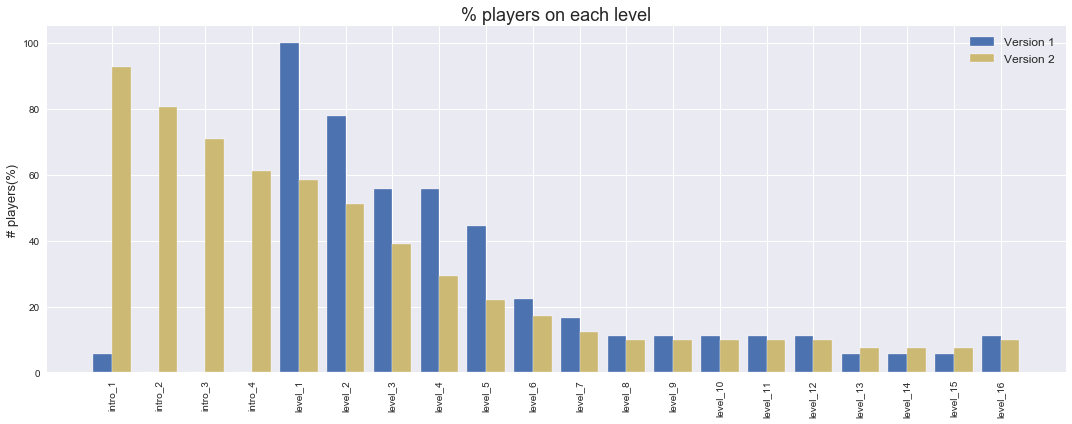

In [29]:
plt.style.use('seaborn')
level_list = ['intro_1', 'intro_2', 'intro_3', 'intro_4', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5', 'level_6', 
        'level_7', 'level_8', 'level_9', 'level_10', 'level_11', 'level_12', 'level_13', 'level_14', 'level_15', 'level_16']
label_list = np.arange(len(level_list))  
x = label_list
barwidth = 0.4

fig, axs = plt.subplots(figsize=(15, 6))
bar1 = axs.bar(x-barwidth/2, df_numplayers_level1['pct_players_lvl'], color='C0', edgecolor='white', width=barwidth, label='Version 1') 
bar2 = axs.bar(x+barwidth/2, df_numplayers_level2['pct_players_lvl'], color='C4', edgecolor='white', width=barwidth, label='Version 2')

axs.set_xticks(x)
axs.set_xticklabels(level_list, rotation='vertical')
axs.set_ylabel('# players(%)', fontsize=13)
axs.set_title('% players on each level', fontsize=18)

axs.legend(fontsize=12)
fig.tight_layout()
plt.show()

<p>Almost all players who tested both version didn't play the intros' levels. Its average sessions' time (9.78 minutes) is 31.45% longer than the one of the players version 2 (7.44 minutes).</p>

<h3>7. What is average attempts to complete each level?</h3>
<p>Average attempt is total attempt divided by total player.</p>

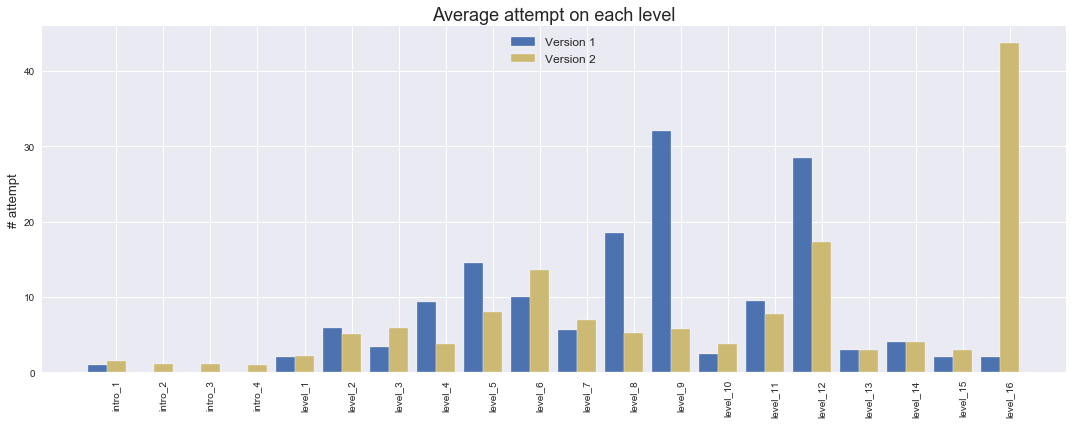

In [30]:
fig, axs = plt.subplots(figsize=(15, 6))
bar1 = axs.bar(x-barwidth, df_numplayers_level1['n_attempt_lvl']/df_numplayers_level1['n_players_lvl'], color='C0', \
               edgecolor='white', width=barwidth, label='Version 1') 
bar2 = axs.bar(x, df_numplayers_level2['n_attempt_lvl']/df_numplayers_level2['n_players_lvl'], color='C4', \
               edgecolor='white', width=barwidth, label='Version 2')

axs.set_xticks(x)
axs.set_xticklabels(level_list, rotation='vertical')
axs.set_ylabel('# attempt', fontsize=13)
axs.set_title('Average attempt on each level', fontsize=18)

axs.legend(fontsize=12)
fig.tight_layout()
plt.show()

<p>Players of version 1 needed to make harder effort to complete the game than the players of version 2. 153.93 and 143.94 attempts respectively. So that, the intros' levels helped players complete the game faster and easier.</p>

In [31]:
print('The total of average attempts:')
print('Version 1: {0:.5g}'.format((df_numplayers_level1['n_attempt_lvl']/df_numplayers_level1['n_players_lvl']).sum()))
print('Version 2: {0:.5g}'.format((df_numplayers_level2['n_attempt_lvl']/df_numplayers_level2['n_players_lvl']).sum()))

The total of average attempts:
Version 1: 153.93
Version 2: 143.94


<h2>8. What level players drop off?</h2>
<p>The number of players who dropped off at any levels is shown using a histogram.</p>

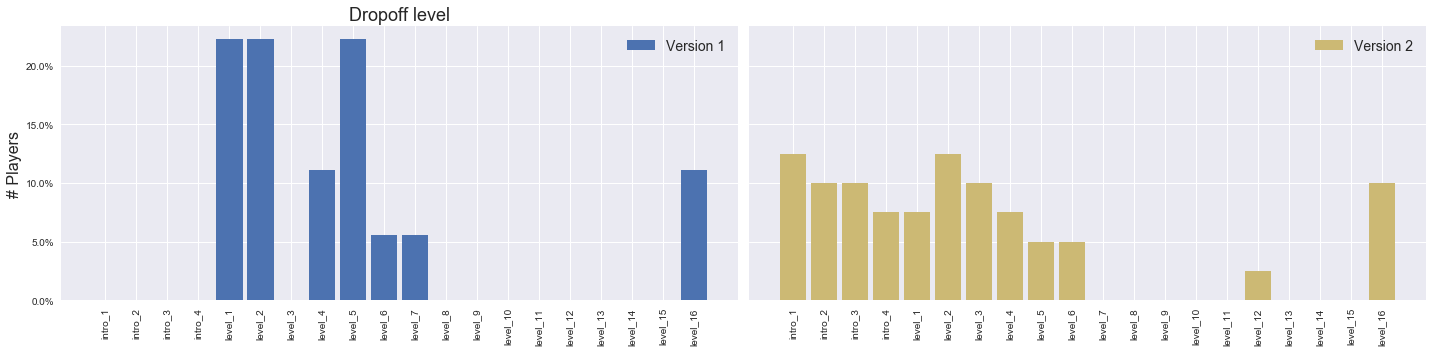

In [32]:
x = level_list
labels = label_list
fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
#axs.set_title('Dropoff level')

bins_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

N, bins, patches = axs[0].hist(df_performance_game1['dropoff_level'], bins_list, density = True, color='C0', rwidth=0.85, \
            label='Version 1')
bin_w = (max(bins_list) - min(bins_list)) / (len(bins_list)-1)
axs[0].set_xticks(np.arange(min(bins_list) + bin_w/2, max(bins_list), bin_w))
axs[0].set_xticklabels(level_list, rotation='vertical')
axs[0].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs[0].set_ylabel('# Players', fontsize=16)
axs[0].set_title('Dropoff level', fontsize=18)
axs[0].legend(fontsize=14)

N, bins, patches = axs[1].hist(df_performance_game2['dropoff_level'], bins_list, density = True, color='C4', rwidth=0.85, \
            label='Version 2')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
axs[1].set_xticks(np.arange(min(bins_list) + bin_w/2, max(bins_list), bin_w))
axs[1].set_xticklabels(level_list, rotation='vertical')
axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs[1].legend(fontsize=14)

fig.tight_layout()

<h2>9. What level a player spends the longest time in - and how it relates to drop-off?</h2>
<p>Both time ranges show that the players usually drop off at their hardest levels or one level higher than their hardest ones.</p>
<p>Please notice that the levels in the column' headers represent the level's labels.</p>
<table>
    <tr>
        <th>Level</th>
        <th>Label</th>
        <th>Level</th>
        <th>Label</th>
        <th>Level</th>
        <th>Label</th>
        <th>Level</th>
        <th>Label</th>
        <th>Level</th>
        <th>Label</th>
    </tr>
    <tr>
        <td>intro_1</td><td>1</td>
        <td>level_1</td><td>5</td>
        <td>level_5</td><td>9</td>
        <td>level_9</td><td>13</td>
        <td>level_13</td><td>17</td>
    </tr>
    <tr>
        <td>intro_2</td><td>2</td>
        <td>level_2</td><td>6</td>
        <td>level_6</td><td>10</td>
        <td>level_10</td><td>14</td>
        <td>level_14</td><td>18</td>
    </tr>
    <tr>
        <td>intro_3</td><td>3</td>
        <td>level_3</td><td>7</td>
        <td>level_7</td><td>11</td>
        <td>level_11</td><td>15</td>
        <td>level_15</td><td>19</td>
    </tr>
    <tr>
        <td>intro_4</td><td>4</td>
        <td>level_4</td><td>8</td>
        <td>level_8</td><td>12</td>
        <td>level_12</td><td>16</td>
        <td>level_16</td><td>20</td>
    </tr>
</table>

In [33]:
# Columns to display
columns = ['PlayerID','game_time', 'dropoff_level', 'longesttime_level']

# Print the dataframe of players who dropped off in Version 1 at the same level as the longest time level
print("Version 1:")
display(df_performance_game1.loc[(df_performance_game1['dropoff_level'] == df_performance_game1['longesttime_level']), \
        columns])
print('{} Players dropped off at one level after their longest time level.'.format(len(df_performance_game1\
        [df_performance_game1['dropoff_level'] == (df_performance_game1['longesttime_level']+1)])))

# Print the dataframe of players who dropped off Version 1: one level higher than the longest time level
display(df_performance_game1.loc[df_performance_game1['dropoff_level'] == (df_performance_game1['longesttime_level']+1), \
       columns])
print('{} Players dropped off at the same level as the longest time level.'.format(len(df_performance_game1\
        [df_performance_game1['dropoff_level'] == df_performance_game1['longesttime_level']])))

# Display the total percentage of dropped off players
print('It means {0:.2f} % players dropped off at the same level or one level higher than their hardest level.'\
      .format((len(df_performance_game1[df_performance_game1['dropoff_level'] == df_performance_game1['longesttime_level']])\
      + len(df_performance_game1[df_performance_game1['dropoff_level'] == df_performance_game1['longesttime_level']]))\
      / len(realplayer_list1) * 100))

Version 1:


,PlayerID,game_time,dropoff_level,longesttime_level
0,178D2D7F-0807-40A4-8CB6-1C72827757E0,977.0,8,8
2,1e5027b875d96315a3968cb615f97bc1,93.0,5,5
3,3417ae618b7f94395b189d034b31b563,178.0,6,6
4,41860341-36A0-4518-895D-0A6637910ED9,3783.0,11,11
8,78f12bed2c4d50ee1b25326b8de097ea,12.0,5,5
9,7e756ea8713052745c4b876e2df49aa2,54.0,5,5


6 Players dropped off at one level after their longest time level.


,PlayerID,game_time,dropoff_level,longesttime_level
7,69ee9067ae6f981f26201a04aab95d5d,311.0,6,5
10,A72CE080-9DDF-4137-81A4-8A108D99120D,1105.0,9,8
11,C20D6891-65C5-401C-BBEE-136D5022DC74,138.0,6,5
15,eaf3cb5c3c66dbabd17c130e8ac567a5,2324.0,9,8
16,eeb145810509522b6cff8900eb3b1d99,1593.0,9,8
17,f8cdb8648d2d0e9af695200baf8b02fc,483.0,8,7


6 Players dropped off at the same level as the longest time level.
It means 66.67 % players dropped off at the same level or one level higher than their hardest level.


In [34]:
print("Version 2:")

# Print the dataframe of Version 2 players who dropped off at the same level as the longest time level
display(df_performance_game2.loc[(df_performance_game2['dropoff_level'] == df_performance_game2['longesttime_level']), \
        columns])
print('{} Players dropped off at one level after their longest time level.'.format(len(df_performance_game2\
        [df_performance_game2['dropoff_level'] == (df_performance_game2['longesttime_level'])])))

# Print the dataframe of Version 2 players who dropped off one level higher than the longest time level
display(df_performance_game2.loc[df_performance_game2['dropoff_level'] == (df_performance_game2['longesttime_level']+1), \
       columns])
print('{} Players dropped off at the same level as the longest time level.'.format(len(df_performance_game2\
        [df_performance_game2['dropoff_level'] == df_performance_game2['longesttime_level']+1])))

# Display the total percentage of dropped off players
print('It means {0:.2f} % players dropped off at the same level or one level higher than their hardest level.'\
      .format((len(df_performance_game2[df_performance_game2['dropoff_level'] == df_performance_game2['longesttime_level']])\
      + len(df_performance_game2[df_performance_game2['dropoff_level'] == df_performance_game2['longesttime_level']+1]))\
      / len(realplayer_list2) * 100))

Version 2:


,PlayerID,game_time,dropoff_level,longesttime_level
1,07D96C0C-48D4-458D-9973-C3095C5CF7CB,22.0,1,1
2,101f3c83de581c5c016cf8aab44ba10f,833.0,7,7
5,1D331EF6-0913-442C-86A4-A9C598D84EDF,1484.0,6,6
6,212675EB-EAD6-40F7-8170-BD15C5440FB4,11622.0,20,20
8,2BC8F220-EC01-4E7B-9A83-7CDFE6944C8E,1795.0,10,10
10,3717c31fe2b92784e9eda2785b61cbd2,15.0,1,1
11,41A1B32D-0CD1-4FEA-8670-608D5D2CFCCC,372.0,6,6
14,4a239d36c2df709e62eedf442056d729,1217.0,7,7
22,986b13d0c05bc77ff8a0e407713c4275,319.0,7,7
23,9c7dd13e06c279e70f626c0409211ca3,574.0,7,7


15 Players dropped off at one level after their longest time level.


,PlayerID,game_time,dropoff_level,longesttime_level
4,190E7EF8-028A-47FC-892E-45E84592DDCE,67.0,2,1
7,22f2885f1c8bed90b434d2778d8b37be,1522.0,8,7
17,6e1666b3f83fe0d7d3def47ea03467ea,1222.0,8,7
19,7FA54B7B-90E6-4A5C-ACC7-0B840D9F1DD6,75.0,2,1
35,ECB63E16-75A4-4813-9ED6-20A0280AF728,1079.0,8,7
38,b709dbabbfe2680cab92a676262b6d0a,70.0,2,1
40,e599ec4650d6eb77dc88f403958b793d,310.0,6,5


7 Players dropped off at the same level as the longest time level.
It means 53.66 % players dropped off at the same level or one level higher than their hardest level.


<h2>10. What is the players' favorite winning team?</h2>

In [35]:
# The top 3 winning team of Version 1
print("Version 1: ")
print(df_winning_team1.head(3))

# The top 3 winning team of Version 2
print("Version 2: ")
print(df_winning_team2.head(3))

Version 1: 
                        Team  #winning
0        Bob,Cloud,Fya,Marto        36
1    Bob,Cloud,Fya,Sir Atcha         2
2  Cloud,Doori,Fya,Sir Atcha         4
Version 2: 
                        Team  #winning
0        Bob,Cloud,Fya,Marto       175
1  Cloud,Fya,Marto,Sir Atcha         3
2      Cloud,Doori,Fya,Marto         3


<p>The most favorite winning team is Bob,Cloud,Fya,Marto.</p>

<h2>11. Summary</h2>
<table>
<tr>
    <th>Measures</th>
    <th>Version 1</th>
    <th>Version 2</th>
<tr>
    <tr>
        <td>Number of players</td>
        <td>18</td>
        <td>41</td>
    </tr>
    <tr>
        <td>Average session per player</td>
        <td>9.78 minutes</td>
        <td>7.44 minutes</td>
    </tr>     
    <tr>
        <td>Average attempts per player</td>
        <td>153.93</td>
        <td>143.94</td>
    </tr>      
    <tr>
        <td>Players dropped-off at the same or one higher than their longest time's level</td>
        <td>66.67 %</td>
        <td>53.66 %</td>
    </tr>
    <tr>
        <td>Number of players won the highest level</td>
        <td>0</td>
        <td>3 people (7.32 %)</td>
    </tr>    
</table>


<p>The players of version 2 were advised to play the intro levels. Even though they played more levels than the version 1's players, they finished the game faster with less effort. Furthermore, there are 7.32 % players completed the highest level of version 2, compare with none of version 1. Based on the above numbers, it is recommended to the players to play the intro levels to succeed at the game.</p>